In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pylab import rcParams
from sklearn.datasets import load_boston
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.utils import shuffle

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

In [39]:
#Считываем данные из файла
data = pd.read_csv('train.csv')

# Разбивка данных

In [40]:
#Разбивка Data на тренировачный и валидатационный датасет
from sklearn.model_selection import train_test_split
train, valid = train_test_split(data, test_size=0.2, random_state=42)
train.shape, valid.shape

((8000, 20), (2000, 20))

In [41]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9254,12473,58,1.0,65.271225,62.798045,1.0,3,1.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,210849.693542
1561,14050,146,2.0,45.091598,43.816601,1.0,5,18.0,2017,0.236108,B,B,16,3893,27,NaN,3,10,B,201549.998077
1670,3779,5,1.0,34.463114,20.561823,5.0,3,5.0,1960,0.150818,B,B,16,3433,4,2643.0,4,5,B,158433.168775
6087,3762,90,3.0,61.931107,46.126389,5.0,4,5.0,1966,0.265089,B,B,37,5288,0,1937.0,3,2,B,220194.818430
6669,358,1,1.0,42.670840,NaN,1.0,8,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,125834.270291


In [42]:
train.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

In [43]:
col = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2']

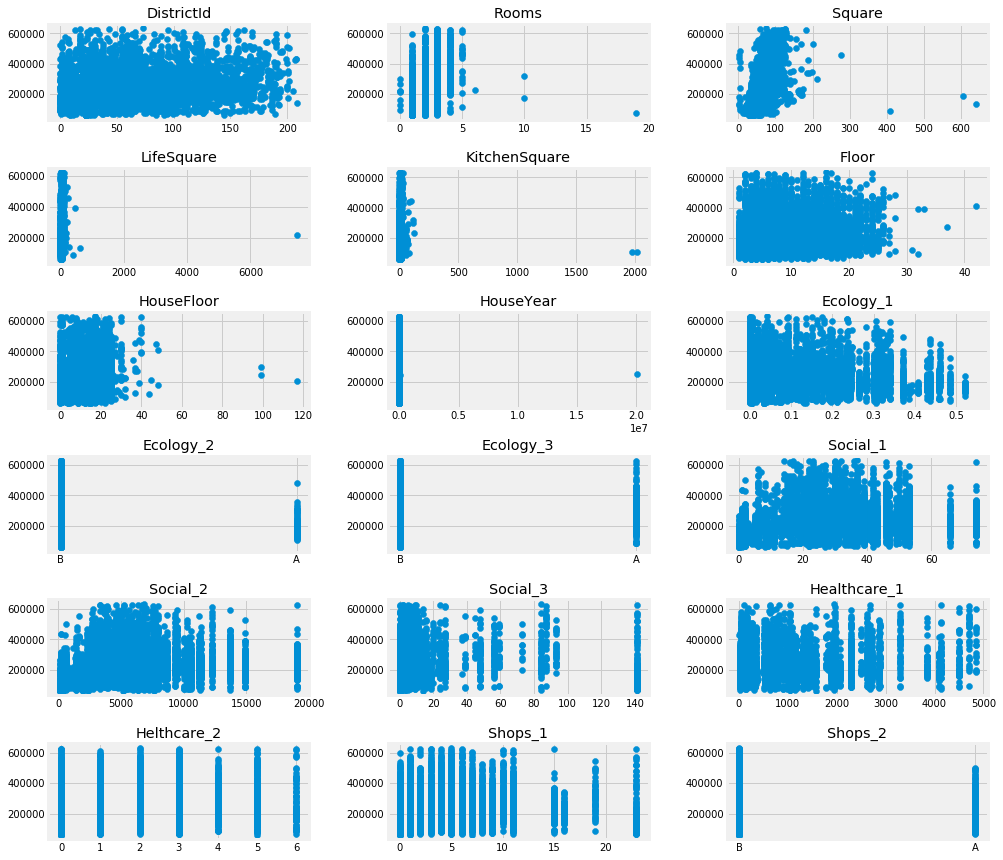

In [44]:
#визуализируем данные
fig, ax = plt.subplots(nrows=6, ncols=3)
ax = ax.flatten()
for i, j in enumerate(col):
    ax[i].scatter(data[j], data['Price'])
    ax[i].set_title(j)
fig.set_size_inches(15, 15)
plt.subplots_adjust(wspace=0.3, hspace=0.5)

In [45]:
#из графиков видно, что некоторые данны выбиваются из обще массы

# Обработка даннх

Т.к. 10 000 считаем что данных мало, поэтому придерживаемся варианта не удаления данных, а заменна средним значением

In [46]:
def clean_house_year(df):
    # Год больше 2020 заменяем 2020
    df.loc[df['HouseYear'] > 2020 , 'HouseYear' ] = 2020 
    return df

In [47]:
def clean_house_floor(df):
    # Самое высокое жилое сдание в России на 2019 г. "Башня Федерация" 62 этажа
    df.loc[df['HouseFloor'] > 62 , 'HouseFloor'] = 62
    df.loc[df['HouseFloor'] < 1 , 'HouseFloor'] = 1
    return df

In [48]:
def clean_floor(df):
    #этаж квартиры не может быть больше этажности дома
    df.loc[(df['Floor']>df['HouseFloor']) & (df['Floor'].isnull() != True ), 'HouseFloor'] = df['Floor']
    return df

In [49]:
def clean_rooms(df):
    # заменим 0 комнаты на 1 и комнаты больше 5 заменим 5
    #df.loc[df['Rooms'] > 5 , 'Rooms'] = 5
    df.loc[df['Rooms'] < 1 , 'Rooms'] = None    
    return df

In [50]:
def clean_square(df):
    #Принимаем гипотезу
    df.loc[df['Square']/df['Rooms'] < 9.0 , 'Square' ] = df['Square'].mean()
    df.loc[df['Square'] < 15.0 , 'Square' ] = df['Square'].mean()
    df.drop(df[df.Square > 250.0].index, inplace=True)
    df.drop(df[df.Square < 15.0].index, inplace=True)
    return df

In [51]:
def clean_kitchen_square(df):
    df.loc[df['KitchenSquare'] > df['Square']*0.4 , 'KitchenSquare' ] = df['Square']*0.4
    df.loc[df['KitchenSquare'] < 4 , 'KitchenSquare' ] = df['Square']*0.2
    return df

In [52]:
def clean_life_square(df):
    df.loc[(df['LifeSquare'] < 9) , 'LifeSquare' ] = df['Square']*0.6
    df.loc[(df['LifeSquare'] + df['KitchenSquare'] >  df['Square'])|\
           (df['LifeSquare'].isnull()), 'LifeSquare' ] = df['Square'] - df['KitchenSquare']
    return df

In [53]:
def add_ground_floor(df):    
    df['ground_floor'] = (df['Floor'] ==1).astype(int)
    df['high_floor'] = (df['Floor'] ==df['HouseFloor']).astype(int)
    return df

In [54]:
def add_district(df, distr_info1):
    df = pd.merge(df, distr_info1, on='DistrictId', how='left')
    df['is_large'] = df['is_large'].fillna(0)
    df['large_district'] = df['large_district'].fillna(1)   
    return df

In [55]:
def translation_of_indicators(df):
    df['Ecology_2'] = (df['Ecology_2'] == 'A').astype(int)
    df['Ecology_3'] = (df['Ecology_3'] == 'A').astype(int)
    df['Shops_2'] = (df['Shops_2'] == 'A').astype(int)
    return df

In [56]:
def add_test(df):    
    df['test'] = ['Square']/df['Rooms']
    return df

In [57]:
distr_info1 = train['DistrictId'].value_counts().reset_index().\
    rename(columns={'index':'DistrictId', 'DistrictId':'large_district'})
distr_info1['is_large'] = (distr_info1['large_district'] > 100).astype(int)


In [58]:
def prepare_data(df, distr_info1):
    df = clean_house_year(df)
    #df = clean_house_floor(df)
    df = clean_floor(df)
    #df = clean_rooms(df)
    #df = clean_square(df)
    #df = clean_kitchen_square(df)
    df = clean_life_square(df)
    df = add_ground_floor(df)
    df = add_district(df, distr_info1)
    #df = add_test(df)
    df = translation_of_indicators(df)
    return df

In [59]:
train = prepare_data(train, distr_info1) 
valid = prepare_data(valid, distr_info1) 

In [60]:
train['HouseYear'].mean

<bound method Series.mean of 0       1977
1       2017
2       1960
3       1966
4       1977
5       1973
6       1977
7       1977
8       1977
9       2014
10      2012
11      1962
12      1931
13      1964
14      1977
15      1964
16      1977
17      1977
18      1977
19      1969
20      2017
21      1977
22      2017
23      1977
24      1977
25      1928
26      2007
27      1977
28      1977
29      1977
        ... 
7970    2014
7971    1975
7972    2012
7973    1977
7974    1977
7975    2016
7976    1979
7977    2002
7978    1997
7979    1977
7980    1975
7981    2016
7982    1977
7983    1986
7984    1969
7985    2016
7986    1977
7987    1978
7988    2018
7989    1974
7990    1977
7991    1984
7992    1996
7993    1977
7994    2006
7995    2015
7996    2018
7997    1977
7998    1973
7999    1993
Name: HouseYear, Length: 8000, dtype: int64>

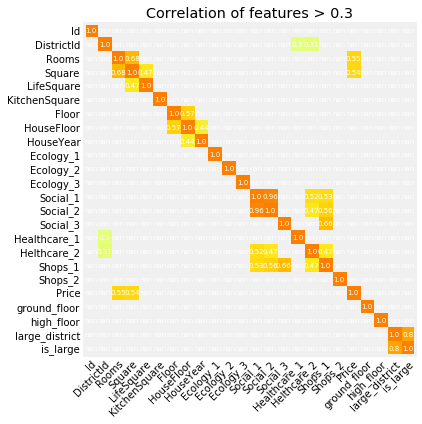

In [61]:
data_columns = train.columns
correlation = train.corr()
# прорисовываем температурную карту (heatmap) по перекрессной корреляции показателей
# для определения наиболее взаимозависимых показателей

# Размер графика
rcParams['figure.figsize'] = 6, 6
# Задаем отсекающий коэффициент корреляции. Ниже этого коэфф. считаем, что корреляция пары показателей не сильная.
correlation_rate_filter = 0.3

#Определяем колонки, столбцы и данные для построение heatmap
hm_index = correlation.index
hm_colums = correlation.columns
hm_data = np.array(correlation.where(correlation > abs(correlation_rate_filter))).round(2)


fig, ax = plt.subplots()
im = ax.imshow(hm_data, cmap="Wistia")

# Столбцы и индексы
ax.set_xticks(np.arange(len(hm_colums)))
ax.set_yticks(np.arange(len(hm_index)))
ax.set_xticklabels(hm_colums)
ax.set_yticklabels(hm_index)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Подписи к столбцам и индексам.
for i in range(len(hm_index)):
    for j in range(len(hm_colums)):
        text = ax.text(j, i, hm_data[i, j],
                       ha="center", va="center", color="w", fontsize=7)

ax.set_title(f"Correlation of features > {correlation_rate_filter}")
fig.tight_layout()
plt.grid()
plt.show()

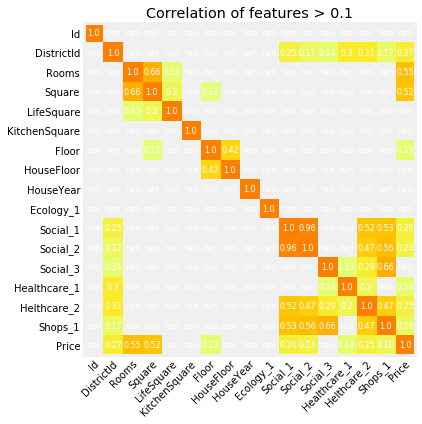

In [62]:
data_columns = data.columns
correlation = data.corr()
# прорисовываем температурную карту (heatmap) по перекрессной корреляции показателей
# для определения наиболее взаимозависимых показателей

# Размер графика
rcParams['figure.figsize'] = 6, 6
# Задаем отсекающий коэффициент корреляции. Ниже этого коэфф. считаем, что корреляция пары показателей не сильная.
correlation_rate_filter = 0.1

#Определяем колонки, столбцы и данные для построение heatmap
hm_index = correlation.index
hm_colums = correlation.columns
hm_data = np.array(correlation.where(correlation > abs(correlation_rate_filter))).round(2)


fig, ax = plt.subplots()
im = ax.imshow(hm_data, cmap="Wistia")

# Столбцы и индексы
ax.set_xticks(np.arange(len(hm_colums)))
ax.set_yticks(np.arange(len(hm_index)))
ax.set_xticklabels(hm_colums)
ax.set_yticklabels(hm_index)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Подписи к столбцам и индексам.
for i in range(len(hm_index)):
    for j in range(len(hm_colums)):
        text = ax.text(j, i, hm_data[i, j],
                       ha="center", va="center", color="w", fontsize=8)

ax.set_title(f"Correlation of features > {correlation_rate_filter}")
fig.tight_layout()
plt.grid()
plt.show()

# Модель 

In [63]:
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.metrics import r2_score as r2

In [64]:
model = RF(n_estimators=88, max_depth=20, random_state=42)

In [65]:
train.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'ground_floor',
       'high_floor', 'large_district', 'is_large'],
      dtype='object')

In [66]:
feats = ['Rooms', 'Square', 'KitchenSquare',
            'HouseFloor', 'HouseYear', 'Ecology_1',
       'Ecology_3', 'Social_2', 'Social_3', 'Helthcare_2',
             'Shops_1', 'ground_floor','high_floor','large_district', 'is_large']

In [67]:
model.fit(train.loc[:, feats], train['Price'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=88, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [68]:
def evaluate_model(df, model=model, feats=feats, calculate_r2='Yes'):
    pred = model.predict(df.loc[:, feats])
    if calculate_r2 == 'Yes':
        r2_ = r2(df['Price'], pred)
        print('R2: {}'.format(r2_))
    return pred

In [69]:
pred_train = evaluate_model(train)

R2: 0.9608776995782099


In [70]:
pred_valid = evaluate_model(valid)

R2: 0.7318092914691776


R2: 0.7310021580883181

Text(0,0.5,'Площадь квартиры')

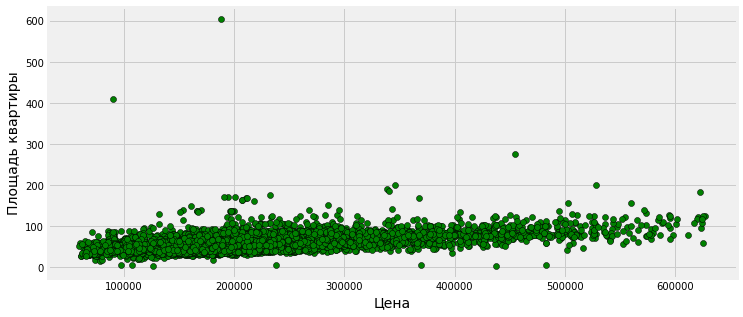

In [71]:
plt.figure(figsize=(11, 5))
sc1 = plt.scatter(train['Price'], train['Square'], edgecolors='black', color='g')
plt.xlabel('Цена', fontsize=14)
plt.ylabel('Площадь квартиры', fontsize=14)

In [72]:
mdepth = range(10,50)
est =range(10,150)
max_r2=0
dip=0
e=0
max_est = 0
score = []
r2_est = []

for i in mdepth:
    rf = RF(n_estimators=90, max_depth=i, random_state=42)
    rf.fit(train.loc[:, feats], train['Price'])
    pred1 = rf.predict(valid.loc[:, feats])
    sc = r2(valid['Price'], pred1)
    if sc > max_r2:
        max_r2 = sc
        dip = i
    score.append(sc)
for i in est:
    rf = RF(n_estimators=i, max_depth=dip, random_state=42)
    rf.fit(train.loc[:, feats], train['Price'])
    pred1 = rf.predict(valid.loc[:, feats])
    sc = r2(valid['Price'], pred1)
    if sc > max_est:
        max_est = sc
        e = i
    r2_est.append(sc)

In [73]:
print('Лучший показатель R2 =', max_est,'получается при: max_depth =',dip,'и n_estimators = ',e)

Лучший показатель R2 = 0.7318092914691776 получается при: max_depth = 20 и n_estimators =  88


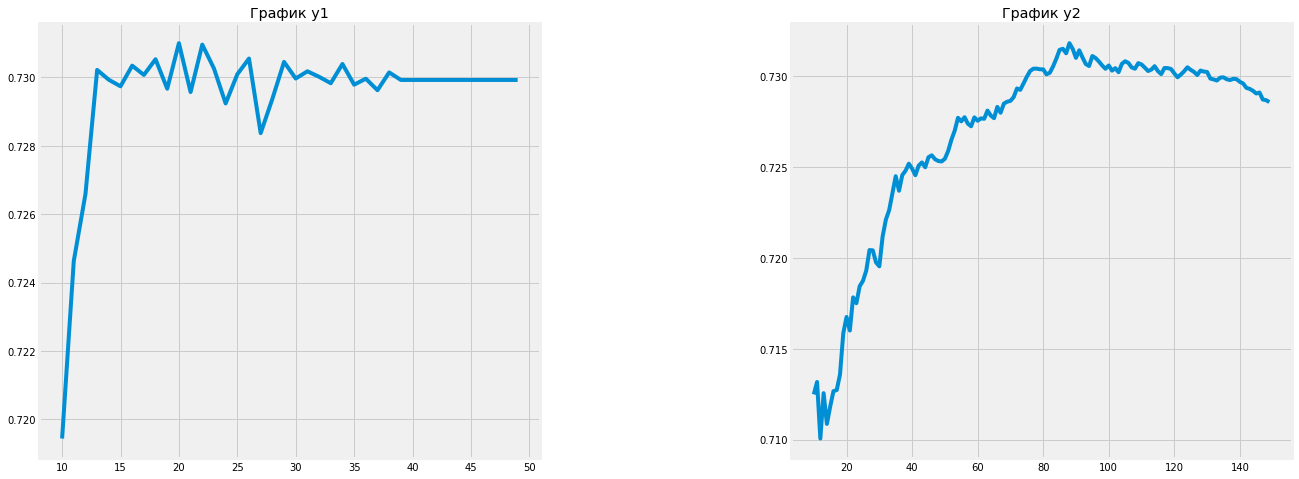

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=2)
[ax1, ax2] = ax
ax1.plot(mdepth, score)
ax1.set_title('График y1')
ax2.plot(est, r2_est)
ax2.set_title('График y2')

fig.set_size_inches(20, 8 )
plt.subplots_adjust(wspace=0.5)
#plt.plot(mdepth, score), plt.plot(est, r2_est)